In [1]:
import pandas as pd
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.mask import mask
import matplotlib.pyplot as plt

from rasterio.plot import show

df = pd.read_csv('./data/soil/HWSD2_csv/HWSD2_LAYERS.csv')




C:\Users\wassim\AppData\Local\Temp\ipykernel_36860\926194529.py:10: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/soil/HWSD2_csv/HWSD2_LAYERS.csv')


In [2]:

pd.set_option('display.max_columns', None)
df.loc[pd.notna(df['PHASE1'])].head(1)


ID  HWSD2_SMU_ID NSC_MU_SOURCE1 NSC_MU_SOURCE2 WISE30s_SMU_ID  \
732  733         12858            NaN            NaN     WD10012858   

     HWSD1_SMU_ID  COVERAGE  SEQUENCE  SHARE  NSC WRB_PHASES  WRB4 WRB2 FAO90  \
732         12858         3         1     60  NaN       PTkk  PTha   PT   ACp   

     ROOT_DEPTH  PHASE1  PHASE2  ROOTS  IL  SWR DRAINAGE    AWC  ADD_PROP  \
732         1.0     1.0     0.0    NaN NaN  NaN        P  119.0       0.0   

    LAYER  TOPDEP  BOTDEP  COARSE  SAND  SILT  CLAY  TEXTURE_USDA  \
732    D1       0      20      16    52    27    21          10.0   

    TEXTURE_SOTER  BULK  REF_BULK  ORG_CARBON  PH_WATER  TOTAL_N  CN_RATIO  \
732             M   1.4      1.74       1.374       4.9     1.26      12.0   

     CEC_SOIL  CEC_CLAY  CEC_EFF  TEB  BSAT  ALUM_SAT  ESP  TCARBON_EQ  \
732         7        14      4.0  3.0    36        23    2         0.0   

     GYPSUM  ELEC_COND  
732     0.0          0

In [3]:
dz = gpd.read_file("data\landcover\dz\dza_gc_adg.shp")
tn = gpd.read_file("data\landcover\\tn\\tun_gc_adg.shp")

combined = gpd.GeoDataFrame(pd.concat([dz, tn], ignore_index=True))

<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\wassim\AppData\Local\Temp\ipykernel_36860\4048785983.py:1: SyntaxWarning: invalid escape sequence '\l'
  dz = gpd.read_file("data\landcover\dz\dza_gc_adg.shp")
C:\Users\wassim\AppData\Local\Temp\ipykernel_36860\4048785983.py:2: SyntaxWarning: invalid escape sequence '\l'
  tn = gpd.read_file("data\landcover\\tn\\tun_gc_adg.shp")


In [4]:


with rasterio.open('./data/soil/HWSD2.bil') as src: 
  # Convert GeoDataFrame geometry to GeoJSON-like dict
    if combined.crs != src.crs:
        combined = combined.to_crs(src.crs)
    
    geoms = [feature["geometry"] for feature in combined.__geo_interface__["features"]]
    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
      "height": out_image.shape[1],
      "width": out_image.shape[2],
      "transform": out_transform
    })
    
    raster_data = out_image[0].astype(float)
    raster_data = np.where(raster_data == src.nodata, np.nan, raster_data)
    print("Raster Clipped")
    

Raster Clipped


In [5]:
df = df.loc[df["LAYER"] == "D1"]



In [6]:
df.head(3)["LAYER"]

666    D1
667    D1
668    D1
Name: LAYER, dtype: object

In [7]:
selected_features = [
    "HWSD2_SMU_ID", "LAYER",  # keep IDs for linking
    "COARSE", "SAND", "SILT", "CLAY",
    "TEXTURE_USDA", "TEXTURE_SOTER",
    "BULK", "REF_BULK", "ORG_CARBON", "PH_WATER",
    "TOTAL_N", "CN_RATIO", "CEC_SOIL", "CEC_CLAY", "CEC_EFF",
    "TEB", "BSAT", "ALUM_SAT", "ESP", "TCARBON_EQ",
    "GYPSUM", "ELEC_COND"
]

df_layer_d1 = df[selected_features]
df_layer_d1.head(3)

HWSD2_SMU_ID LAYER  COARSE  SAND  SILT  CLAY  TEXTURE_USDA TEXTURE_SOTER  \
666         12704    D1       5    67    18    15          11.0             C   
667         12705    D1       5    67    18    15          11.0             C   
668         12707    D1       5    67    18    15          11.0             C   

     BULK  REF_BULK  ORG_CARBON  PH_WATER  TOTAL_N  CN_RATIO  CEC_SOIL  \
666  1.35      1.63       1.062       6.3     0.77      13.0         8   
667  1.35      1.63       1.062       6.3     0.77      13.0         8   
668  1.35      1.63       1.062       6.3     0.77      13.0         8   

     CEC_CLAY  CEC_EFF  TEB  BSAT  ALUM_SAT  ESP  TCARBON_EQ  GYPSUM  \
666        46      6.0  5.0    59         0    2         0.0     0.1   
667        46      6.0  5.0    59         0    2         0.0     0.1   
668        46      6.0  5.0    59         0    2         0.0     0.1   

     ELEC_COND  
666          1  
667          1  
668          1

In [8]:
numeric_props = (
    df_layer_d1.select_dtypes(include=[np.number])
    .columns.drop(["HWSD2_SMU_ID"], errors="ignore")
    .tolist()
)

In [9]:
def plot_soil_property(numeric_props, raster_data, borders, df_joined):
    
    for prop in numeric_props:
        print(f"\n🔹 Generating map for: {prop}")

        lookup = dict(zip(df_joined['HWSD2_SMU_ID'], df_joined[prop]))
        prop_map = np.vectorize(lookup.get)(raster_data).astype(float)
        prop_map = np.ma.masked_invalid(prop_map)

        plt.figure(figsize=(12, 6))
        img = plt.imshow(prop_map, cmap="terrain")

        borders.boundary.plot(ax=plt.gca(), color="black", linewidth=1)
        plt.title(f"Algeria + Tunisia — HWSD2 {prop} (D1 layer, 0–20cm)", fontsize=14)
        plt.xlabel("Longitude (approx.)")
        plt.ylabel("Latitude (approx.)")

        plt.colorbar(img, fraction=0.03, pad=0.04, label=prop)
        plt.tight_layout()
        plt.show()



🔹 Generating map for: COARSE


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


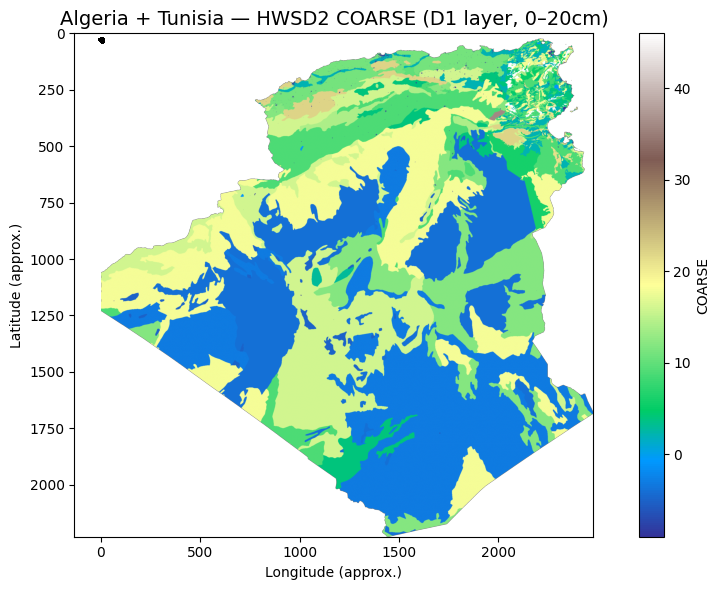


🔹 Generating map for: SAND


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


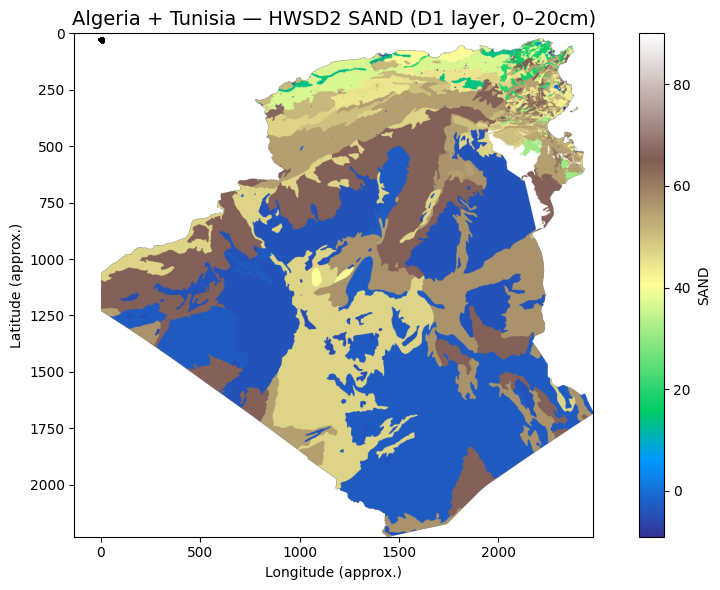


🔹 Generating map for: SILT


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


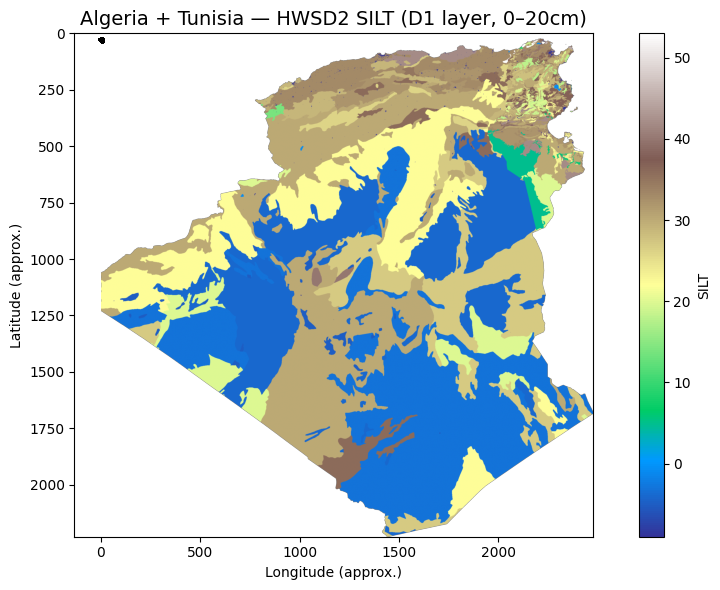


🔹 Generating map for: CLAY


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


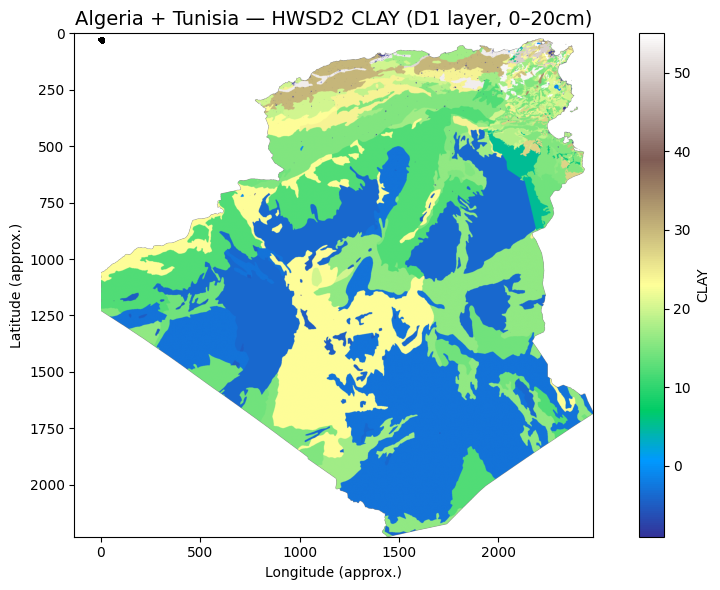


🔹 Generating map for: TEXTURE_USDA


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


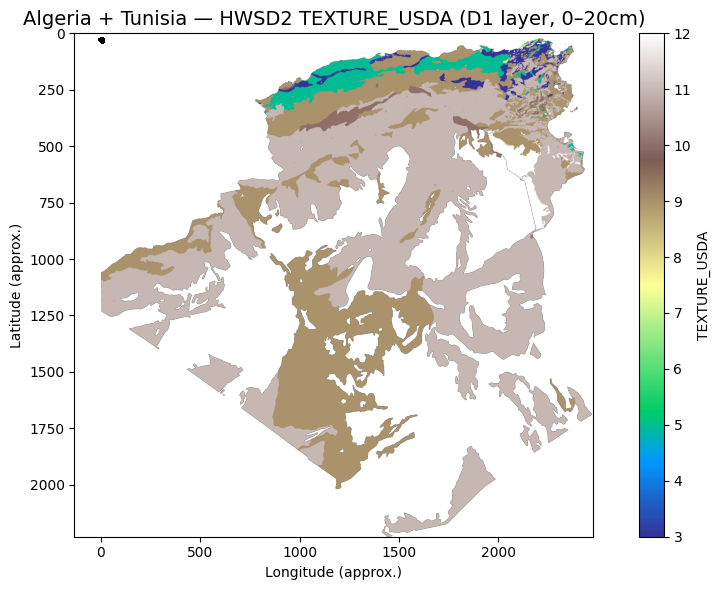


🔹 Generating map for: BULK


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


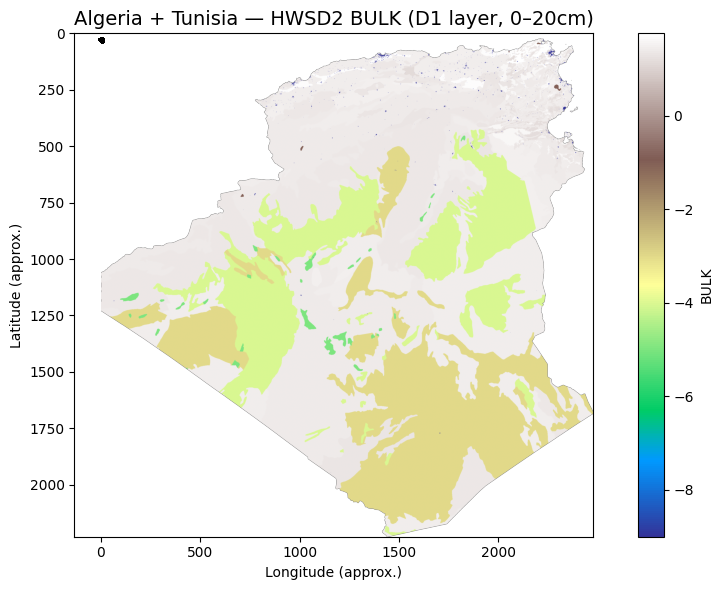


🔹 Generating map for: REF_BULK


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


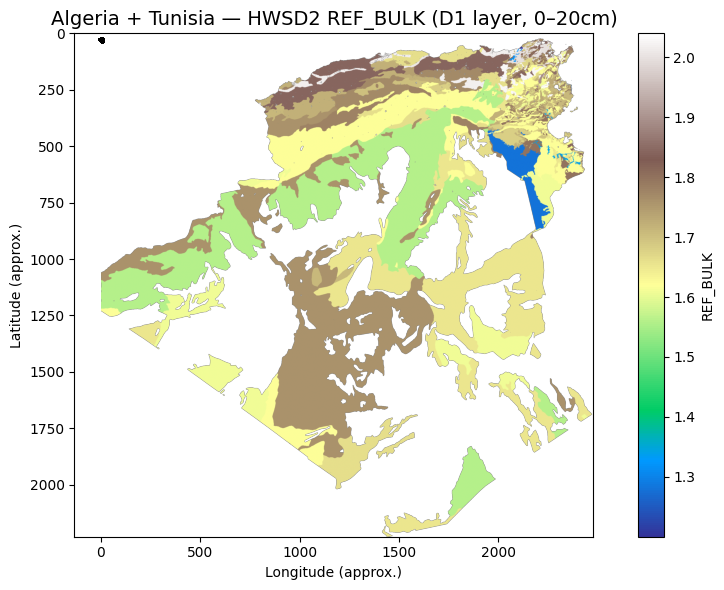


🔹 Generating map for: ORG_CARBON


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


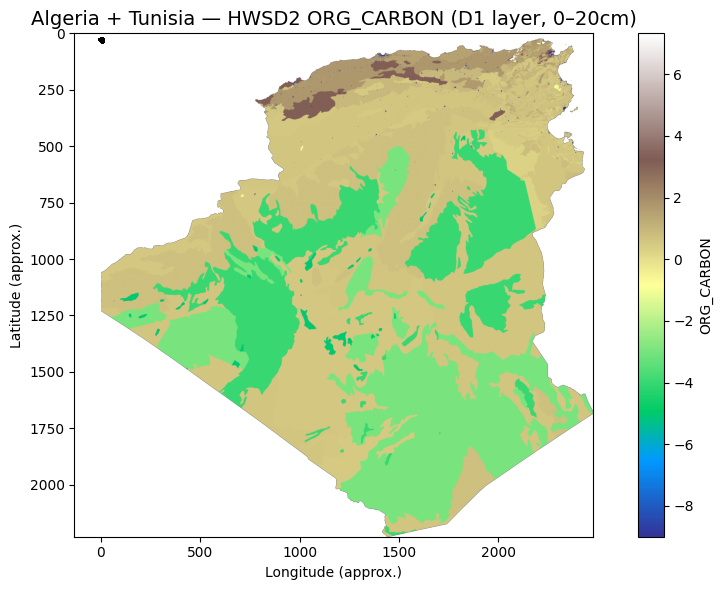


🔹 Generating map for: PH_WATER


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


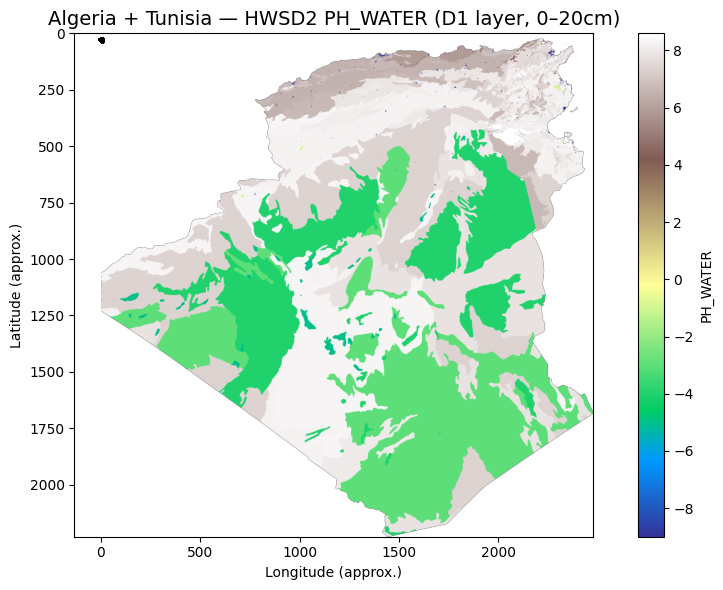


🔹 Generating map for: TOTAL_N


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


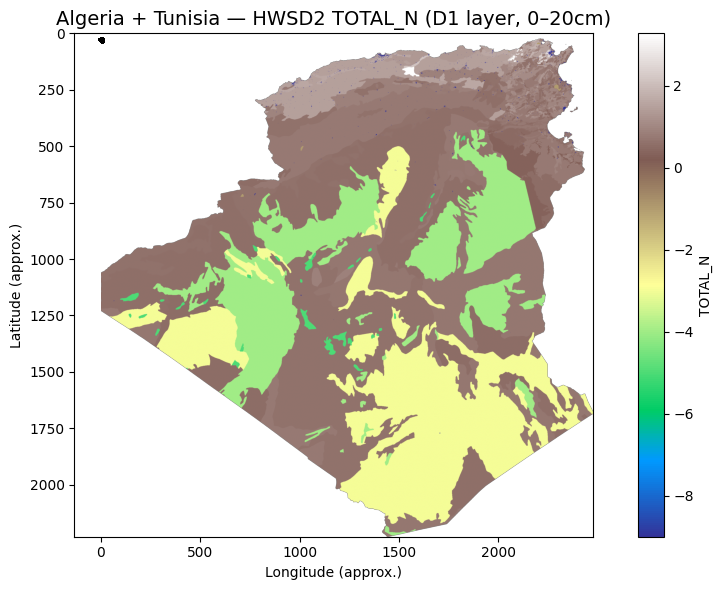


🔹 Generating map for: CN_RATIO


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


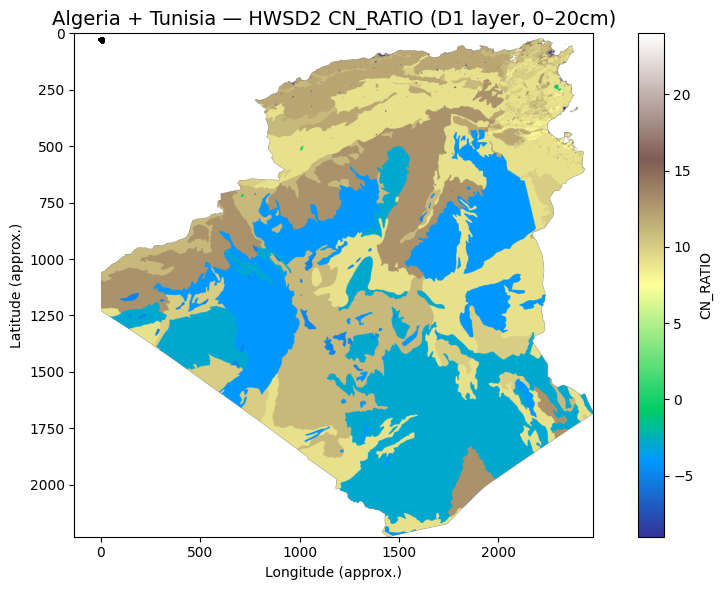


🔹 Generating map for: CEC_SOIL


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


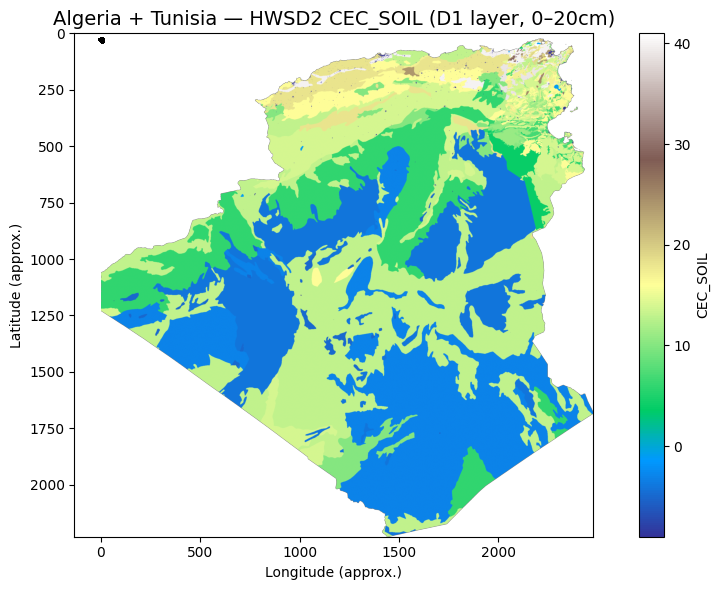


🔹 Generating map for: CEC_CLAY


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


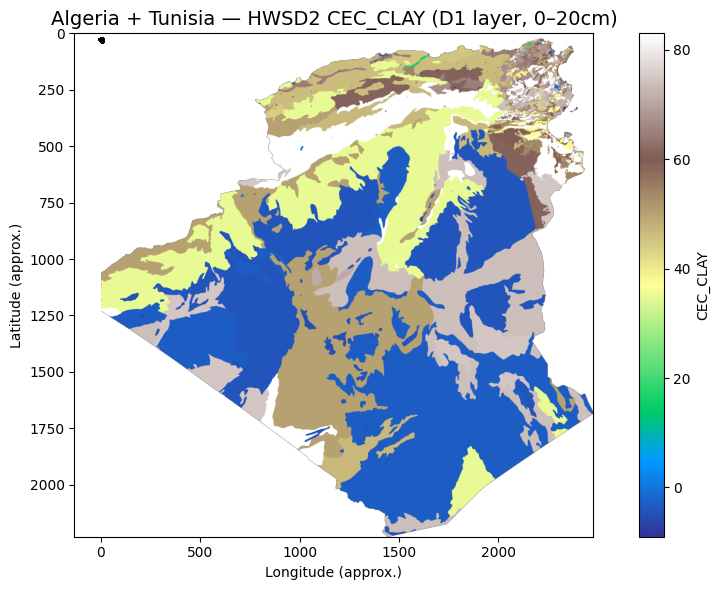


🔹 Generating map for: CEC_EFF


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


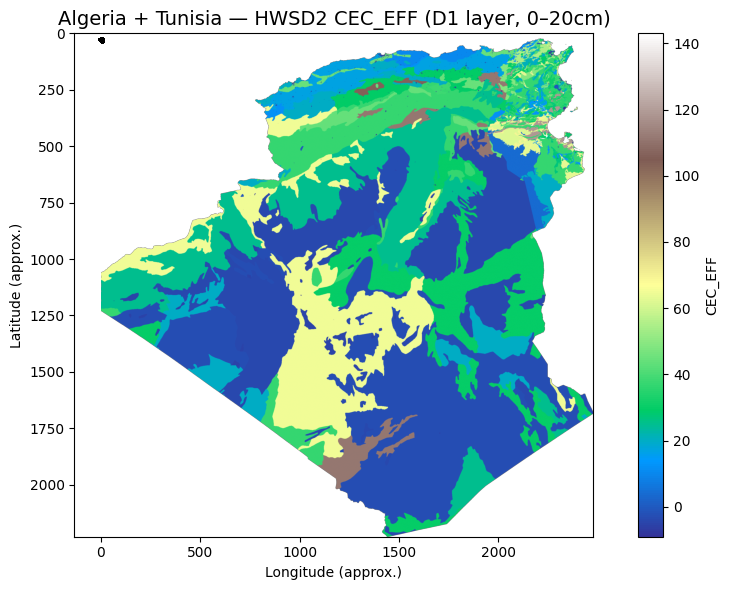


🔹 Generating map for: TEB


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


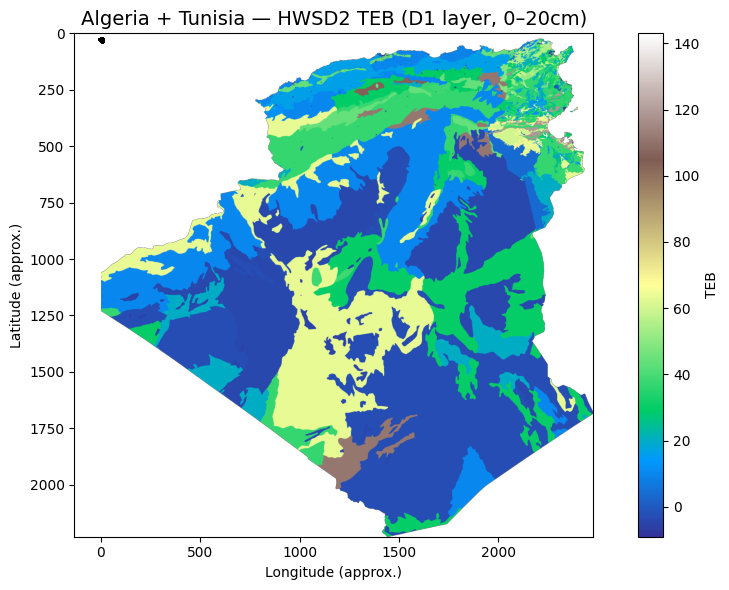


🔹 Generating map for: BSAT


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


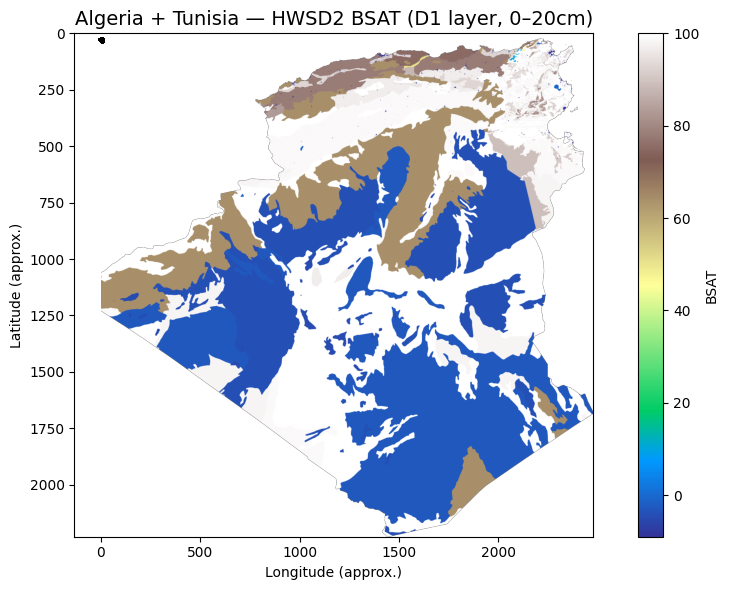


🔹 Generating map for: ALUM_SAT


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


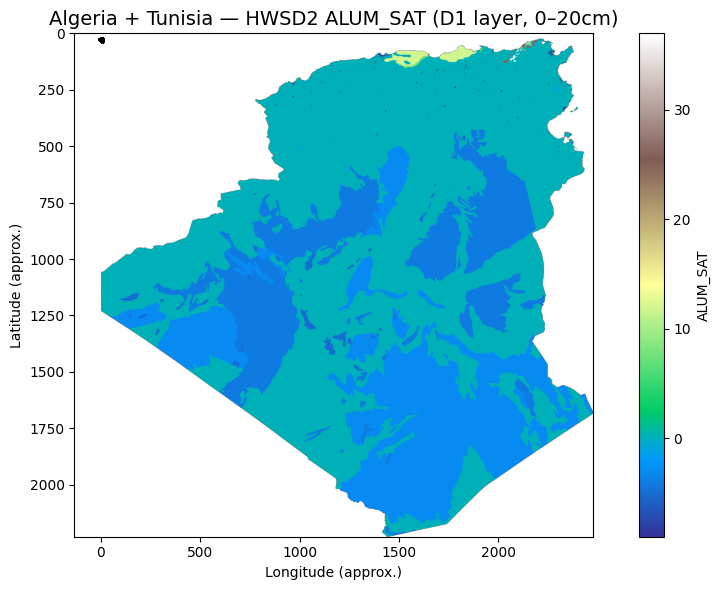


🔹 Generating map for: ESP


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


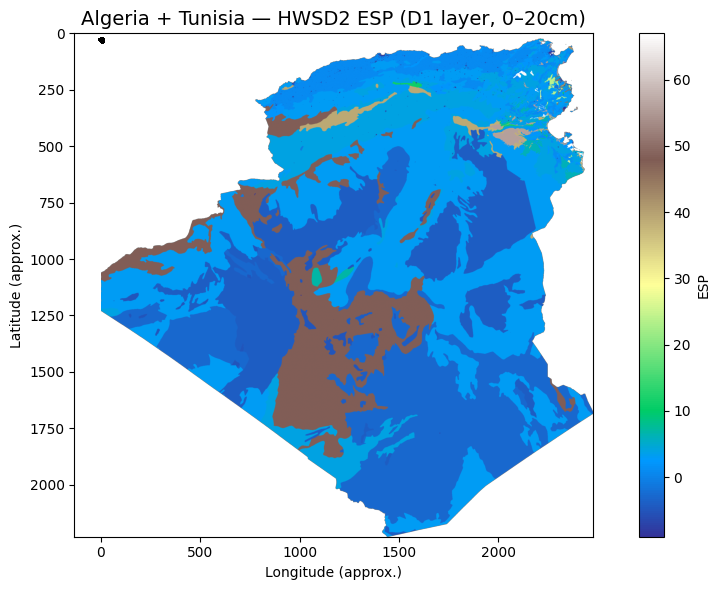


🔹 Generating map for: TCARBON_EQ


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


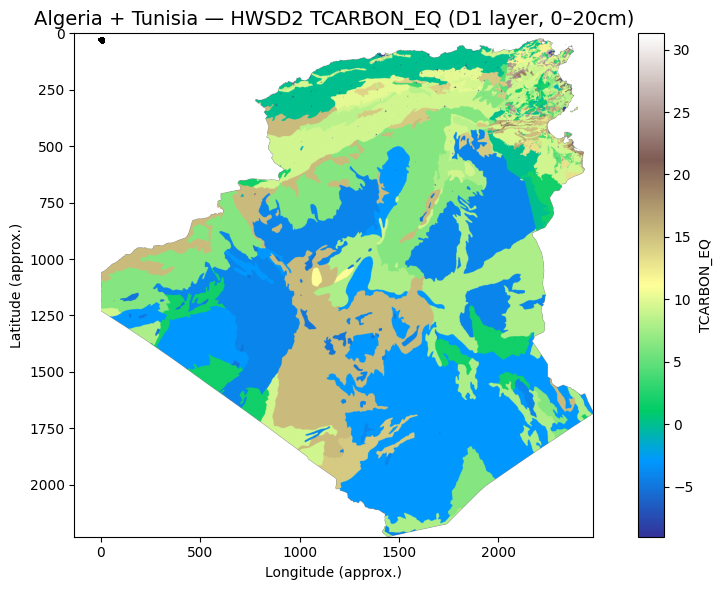


🔹 Generating map for: GYPSUM


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


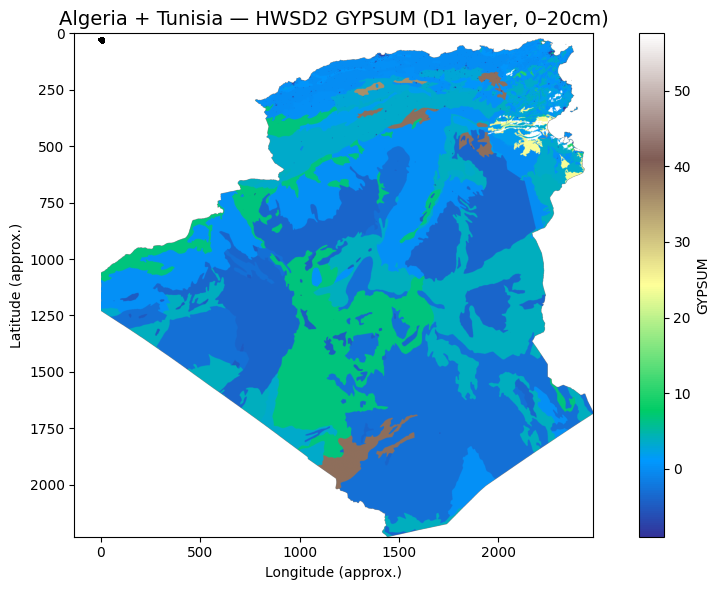


🔹 Generating map for: ELEC_COND


C:\Users\wassim\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


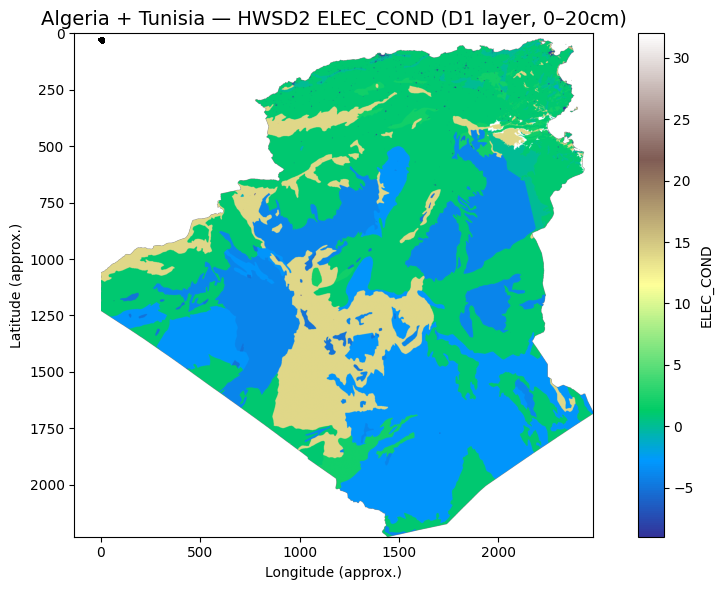

In [10]:
plot_soil_property(numeric_props, raster_data, combined, df_layer_d1)